In [38]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import shutil
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

## Data Exploration

In [2]:
infection_filenames = os.listdir("Data/Infection")

In [3]:
no_infection_filenames = os.listdir("Data/No_Infection")

In [4]:
infection_df = pd.DataFrame({
    'filename': infection_filenames,
})

In [5]:
infection_df['Category'] = 'Infection'

In [6]:
no_infection_df = pd.DataFrame({
    'filename': no_infection_filenames,
})

In [7]:
no_infection_df['Category'] = 'Not Infected'

In [8]:
image_df = pd.concat([infection_df, no_infection_df])

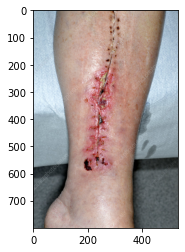

In [9]:
sample = random.choice(infection_filenames)
image = load_img("Data/Infection/"+sample)
plt.imshow(image)

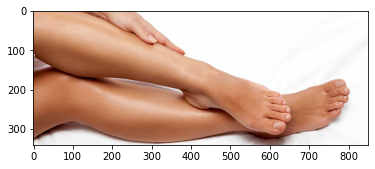

In [10]:
sample = random.choice(no_infection_filenames)
image = load_img("Data/No_Infection/"+sample)
plt.imshow(image)

## Modeling

In [11]:
# rootdir= '/Users/kevinmcdonough/Documents/Flatiron/capstone/project/Capstone/Data/' #path of the original folder

# classes = ['Infection', 'No_Infection']

# for i in classes:
#     os.makedirs(rootdir +'/train/' + i)

#     os.makedirs(rootdir +'/test/' + i)

#     source = rootdir + '/' + i

#     allFileNames = os.listdir(source)

#     np.random.shuffle(allFileNames)

#     test_ratio = 0.25

#     train_FileNames, test_FileNames = np.split(np.array(allFileNames),
#                                                           [int(len(allFileNames)* (1 - test_ratio))])

#     train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
#     test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

#     for name in train_FileNames:
#       shutil.copy(name, rootdir +'/train/' + i)

#     for name in test_FileNames:
#       shutil.copy(name, rootdir +'/test/' + i)

The above code splits the data randomly into train and test sets with the appropriate labels. It only needs to run once so for now I commented it out.

The dataset is pretty small (610 images per class) so we can use data augmentation to create more images

In [12]:
image_size = (300,300)
batch_size = 400
labels = ['Infection','No_Infection']

for label in labels:
  datagen_kwargs = dict(rescale=1./255)  
  dataflow_kwargs = dict(target_size=image_size, 
                        batch_size=batch_size, interpolation="bilinear")

  train_datagen = ImageDataGenerator(
    rotation_range=20,
    vertical_flip=True,
    width_shift_range=0.5, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1,
    **datagen_kwargs)

  train_generator = train_datagen.flow_from_directory(
      'Data/Train', subset="training", shuffle=True, save_to_dir='Data/Aug_images/'+label+'/', save_prefix='aug', classes=[label], **dataflow_kwargs)
  
  # Following line triggers execution of train_generator
  batch = next(train_generator) 

Found 454 images belonging to 1 classes.
Found 460 images belonging to 1 classes.


Just to ensure we have enough, let's do one more batch with a horizontal flip and play with some of the other parameters as well. Because these images are closups on the skin, data augmentation makes sense with this dataset. 

In [31]:
image_size = (300,300)
batch_size = 400
labels = ['Infection','No_Infection']

for label in labels:
  datagen_kwargs = dict(rescale=1./255)  
  dataflow_kwargs = dict(target_size=image_size, 
                        batch_size=batch_size, interpolation="bilinear")

  train_datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.2, height_shift_range=0.1,
    shear_range=0, zoom_range=0,
    **datagen_kwargs)

  train_generator = train_datagen.flow_from_directory(
      'Data/Train', subset="training", shuffle=True, save_to_dir='Data/Aug_images/'+label+'/', save_prefix='aug', classes=[label], **dataflow_kwargs)
  
  # Following line triggers execution of train_generator
  batch = next(train_generator) 

Found 454 images belonging to 1 classes.
Found 460 images belonging to 1 classes.


Lastly let's add the original train images in to our augmented folder

In [35]:
classes

['Infection', 'No_Infection']

In [56]:
train_infection_dir = 'Data/train/Infection/'
file_names = os.listdir(train_infection_dir)
train_file_names = [train_infection_dir+'/'+ name for name in file_names]
for name in train_file_names:
    shutil.copy(name, 'Data/Aug_images/Infection')

Now we do the same exercise for the not infected photos

In [57]:
train_no_infection_dir = 'Data/train/No_Infection/'
file_names = os.listdir(train_no_infection_dir)
train_file_names = [train_no_infection_dir+'/'+ name for name in file_names]
for name in train_file_names:
    shutil.copy(name, 'Data/Aug_images/No_Infection/')

awesome! We have now tripled our training set. We are ready to model! 

## Model Building 

In [27]:
image_size = (300,300)
batch_size = 32
image_width = 300
image_height = 300
image_channels = 3

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
train_generator = train_datagen.flow_from_directory(
    "Data/train",
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

Found 914 images belonging to 2 classes.


In [30]:
total_train = len(train_generator.filenames)

In [31]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [32]:
test_generator = test_datagen.flow_from_directory(
    "Data/test/", 
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

Found 302 images belonging to 2 classes.


In [33]:
total_test = len(test_generator.filenames)

In [35]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, image_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 298, 298, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 149, 149, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 710432)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               90935424  
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)              

In [36]:
epochs = 10

history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=test_generator,
    batch_size=batch_size,
    callbacks=callbacks_list
)

Epoch 1/10
29/29 [==============================] - ETA: 0s - loss: 1.2974 - accuracy: 0.6543
Epoch 00001: val_accuracy improved from -inf to 0.60596, saving model to weights.best.hdf5
29/29 [==============================] - 130s 4s/step - loss: 1.2974 - accuracy: 0.6543 - val_loss: 0.6456 - val_accuracy: 0.6060
Epoch 2/10
29/29 [==============================] - ETA: 0s - loss: 0.6039 - accuracy: 0.7287
Epoch 00002: val_accuracy did not improve from 0.60596
29/29 [==============================] - 224s 8s/step - loss: 0.6039 - accuracy: 0.7287 - val_loss: 0.6959 - val_accuracy: 0.5199
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.7877
Epoch 00003: val_accuracy did not improve from 0.60596
29/29 [==============================] - 142s 5s/step - loss: 0.4952 - accuracy: 0.7877 - val_loss: 0.6303 - val_accuracy: 0.5728
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.3438 - accuracy: 0.8512
Epoch 00004: val_accuracy did not

In [47]:
best_model = load_model("weights.best.hdf5")

In [48]:
y_pred = best_model.predict(test_generator)

In [49]:
test_preds = np.argmax(y_pred, axis=-1)

In [50]:
conf = confusion_matrix(test_generator.classes, test_preds)
conf

array([[ 18, 133],
       [ 20, 131]])

In [51]:
test_generator.class_indices

{'Infection': 0, 'No_Infection': 1}

## Model 2 

In [60]:
best_model = load_model("weights.best.h5")

In [61]:
y_pred = best_model.predict(test_generator)

In [62]:
test_preds = np.argmax(y_pred, axis=-1)

In [63]:
conf = confusion_matrix(test_generator.classes, test_preds)
conf

array([[77, 74],
       [79, 72]])